# Applied Data Science - Capstone Project




# Opening a coffee shop in Toronto


## Table of contents

## Introduction

#### Business Problem

Jane Doe, 55 years old and owner of a successful coffee shop in Mahattan, is tired of the Big Apple and looking to sell her existing business and __open a new one in Toronto__, where her extended family lives. 

As she loves the hussle and bussle of the big city she wants to open up shop __in the central area of Toronto__. However, with as many coffee shops as there are in Toronto, it is important to find a neighbourhood with __as little competition as possible__.

#### Target

Our target is Jane Doe, and this project is of interest specifically to her, although could also be relevant for anyone else looking to open up a coffee shop in Toronto.

## Data

First we will define the criteria based on Jane Doe's preferences:
 * Little competition: Fewest coffee shops & similar venues (cafés, delis, breakfast spots, etc.).
 * In the central Toronto area: Boroughs with "Toronto" in the name (e.g. Downtown Toronto, East Toronto, Central Toronto).

The data required will be retrieved from the following sources:
 1. Toronto neighbourhoods geospatial data: https://open.toronto.ca/dataset/neighbourhoods/ (already uploaded to IBM Cloud)
 2. Venues by neighbourhood: https://api.foursquare.com (API)
 4. Venues which could be competition, with assigned weights (self-produced): competition.csv (on IBM Cloud)

Once we have the data we will need to load each one into a dataframe and clean it (e.g. remove NaN's), after which we will need to join 1 and 2 to have a list of Toronto neighbourhoods with their borough and coordinates. After that is done, we will merge this with the Foursquare venue data.

Once the datasets are processed we can determine the Toronto neighbourhoods with the least comeptition.

### Neighbourhood Candidates

#### Lets retrieve all the data we will be using first and prepare it.

To do this, first of all, we initialise all the libraries we will need:

In [1]:
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

In [53]:
import base64

import folium # map rendering library
def _repr_html_(self, **kwargs):
    html = base64.b64encode(self.render(**kwargs).encode('utf8')).decode('utf8')
    onload = (
        'this.contentDocument.open();'
        'this.contentDocument.write(atob(this.getAttribute(\'data-html\')));'
        'this.contentDocument.close();'
    )
    if self.height is None:
        iframe = (
            '<div style="width:{width};">'
            '<div style="position:relative;width:100%;height:0;padding-bottom:{ratio};">'
            '<iframe src="about:blank" style="position:absolute;width:100%;height:100%;left:0;top:0;'
            'border:none !important;" '
            'data-html={html} onload="{onload}" '
            'allowfullscreen webkitallowfullscreen mozallowfullscreen>'
            '</iframe>'
            '</div></div>').format
        iframe = iframe(html=html, onload=onload, width=self.width, ratio=self.ratio)
    else:
        iframe = ('<iframe src="about:blank" width="{width}" height="{height}"'
                  'style="border:none !important;" '
                  'data-html={html} onload="{onload}" '
                  '"allowfullscreen" "webkitallowfullscreen" "mozallowfullscreen">'
                  '</iframe>').format
        iframe = iframe(html=html, onload=onload, width=self.width, height=self.height)
    return iframe

folium.branca.element.Figure._repr_html_ = _repr_html_

In [54]:
#!conda install -c conda-forge geopandas --yes
import geopandas as gpd # library for spatial data analysis

In [55]:
#!conda install -c conda-forge descartes
import descartes

In [56]:
import numpy as np # library to handle data in a vectorized manner
#!conda install -c conda-forge pandas
import pandas as pd # library for data analsysis
import requests # library to handle requests
import json # library to handle JSON files

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans # import k-means from clustering stage
from bs4 import BeautifulSoup # parse Wikipedia table data
#from project_lib import Project

Credentials for Fourquare API calls (in a hidden cell):

In [57]:
# @hidden_cell

# Foursquare credentials
CLIENT_ID = 'O513S2TN1NSFKO2HLDEMMOTK4E4ECUD1O4BRRM1XGO5EKUNW' # your Foursquare ID
CLIENT_SECRET = 'DSRXGSTWD5YQBX1ELGNGNQP5DEVBX1HCGVH3BLIUOLJWRHTF' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version


Now we are ready to retrieve all the data we will be using. Lets start by getting the Toronto neighbourhoods and putting them into a dataframe:

In [58]:
# Fetch the file and load it into a geopandas dataframe
#geo_json_data = json.loads('Neighbourhoods.geojson')
with open('Neighbourhoods.geojson') as json_data:
    nbhd_gjson = json.load(json_data)
#   toronto_data = json.load(json_data)
#file_nhoods = project.get_file("Neighbourhoods.geojson")
#file_nhoods.seek(0)
# Load it into a geodataframe
toronto_data = gpd.read_file('Neighbourhoods.geojson')
toronto_data

,_id,AREA_ID,AREA_ATTR_ID,PARENT_AREA_ID,AREA_SHORT_CODE,AREA_LONG_CODE,AREA_NAME,AREA_DESC,X,Y,LONGITUDE,LATITUDE,OBJECTID,Shape__Area,Shape__Length,geometry
0,5461,25886861,25926662,49885,94,94,Wychwood (94),Wychwood (94),None,None,-79.425515,43.676919,16491505,3.217960e+06,7515.779658,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,5462,25886820,25926663,49885,100,100,Yonge-Eglinton (100),Yonge-Eglinton (100),None,None,-79.403590,43.704689,16491521,3.160334e+06,7872.021074,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,5463,25886834,25926664,49885,97,97,Yonge-St.Clair (97),Yonge-St.Clair (97),None,None,-79.397871,43.687859,16491537,2.222464e+06,8130.411276,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,5464,25886593,25926665,49885,27,27,York University Heights (27),York University Heights (27),None,None,-79.488883,43.765736,16491553,2.541821e+07,25632.335242,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,5465,25886688,25926666,49885,31,31,Yorkdale-Glen Park (31),Yorkdale-Glen Park (31),None,None,-79.457108,43.714672,16491569,1.156669e+07,13953.408098,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,5596,25886531,25926797,49885,124,124,Kennedy Park (124),Kennedy Park (124),None,None,-79.260382,43.725556,16493665,6.861056e+06,10530.202433,"POLYGON ((-79.24549 43.73060, -79.24555 43.730..."
136,5597,25886955,25926798,49885,78,78,Kensington-Chinatown (78),Kensington-Chinatown (78),None,None,-79.397240,43.653554,16493681,2.933586e+06,6945.056557,"POLYGON ((-79.40401 43.64719, -79.40419 43.647..."
137,5598,25886737,25926799,49885,6,6,Kingsview Village-The Westway (6),Kingsview Village-The Westway (6),None,None,-79.547863,43.698993,16493697,9.694496e+06,14458.764271,"POLYGON ((-79.55236 43.70947, -79.55229 43.709..."
138,5599,25886763,25926800,49885,15,15,Kingsway South (15),Kingsway South (15),None,None,-79.510577,43.653520,16493713,5.043477e+06,11140.672714,"POLYGON ((-79.51703 43.64611, -79.51717 43.646..."


THere are a number of columns we don't need, so we will drop them

In [59]:
toronto_data.drop(['_id', 'AREA_ID', 'AREA_ATTR_ID', 'AREA_SHORT_CODE', 'AREA_LONG_CODE', 'X'
                   , 'Y', 'AREA_DESC', 'OBJECTID', 'Shape__Area', 'Shape__Length']
                  , axis=1, inplace=True)

And we also remove the number in parenthesis behind the area name, change it to "neighbourhood" and move it to the front

In [60]:
toronto_data['neighbourhood'] = toronto_data['AREA_NAME'].str.replace(' \(.+\)', '')
toronto_data.drop(['AREA_NAME'], axis=1, inplace=True)

to_cols = list(toronto_data)
# move the column to head of list using index, pop and insert
to_cols.insert(0, to_cols.pop(to_cols.index('neighbourhood')))
# use loc to reorder
toronto_data = toronto_data.loc[:, to_cols]

In [61]:
toronto_data.head()

,neighbourhood,PARENT_AREA_ID,LONGITUDE,LATITUDE,geometry
0,Wychwood,49885,-79.425515,43.676919,"POLYGON ((-79.43592 43.68015, -79.43492 43.680..."
1,Yonge-Eglinton,49885,-79.403590,43.704689,"POLYGON ((-79.41096 43.70408, -79.40962 43.704..."
2,Yonge-St.Clair,49885,-79.397871,43.687859,"POLYGON ((-79.39119 43.68108, -79.39141 43.680..."
3,York University Heights,49885,-79.488883,43.765736,"POLYGON ((-79.50529 43.75987, -79.50488 43.759..."
4,Yorkdale-Glen Park,49885,-79.457108,43.714672,"POLYGON ((-79.43969 43.70561, -79.44011 43.705..."


Lets see how this looks on a map of Toronto

In [68]:

toronto_map = folium.Map([43.676919,-79.425515], zoom_start=8)
#   tiles='Mapbox Bright',
#    zoom_start=8  # Limited levels of zoom for free Mapbox tiles.

toronto_map = folium.GeoJson(nbhd_gjson).add_to(toronto_map)

toronto_map
#m = folium.Map([52.5, 2], zoom_start=5.5)
#m

# display(HTML(iframe))

With that done, we go ahead and join the two tables

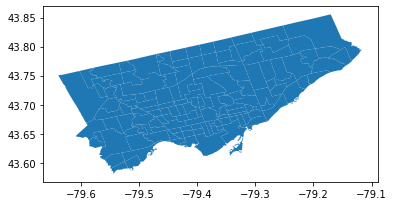

In [63]:
toronto_data.plot()

And select only those Boroughs with "Toronto" in the name

However, we still have a couple of results that we do not want:

* M5W - Stn A PO Boxes  
* M7Y - Business reply mail processing centre

Both of those are clearly not neighbourhoods, so lets remove them and reset the index

In [237]:
toronto_data = toronto_data.drop([34,38], axis=0)
toronto_data.reset_index(drop=True)

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
1,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
2,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937
3,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418
4,M4E,East Toronto,The Beaches,43.676357,-79.293031
5,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306
6,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383
7,M6G,Downtown Toronto,Christie,43.669542,-79.422564
8,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568
9,M6H,West Toronto,"Dufferin, Dovercourt Village",43.669005,-79.442259


Looking good. Time to get the coffeeshop data from Fourquare.

### Foursquare data

Lets start by defining a function to retrieve all venue data for the boroughs we selected previously.

In [238]:
def getNearbyVenues(names, latitudes, longitudes, category="", radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
#        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius,
            category,
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

And we retrieve the data from Fourquare.

In [239]:
LIMIT = 100
RADIUS = 1000
# and then we run the function:
toronto_venues = getNearbyVenues(names=toronto_data['Neighborhood'],
                                   latitudes=toronto_data['Latitude'],
                                   longitudes=toronto_data['Longitude']
                                  )
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Regent Park, Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Bakery
1,"Regent Park, Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Coffee Shop
2,"Regent Park, Harbourfront",43.65426,-79.360636,Morning Glory Cafe,43.653947,-79.361149,Breakfast Spot
3,"Regent Park, Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Distribution Center
4,"Regent Park, Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Spa


In [240]:
toronto_venues.shape

(1501, 7)

#### Now lets clean up the venues to only include possible competition

First lets look at the list of venue categories

In [241]:
toronto_venues['Venue Category'].unique()

array(['Bakery', 'Coffee Shop', 'Breakfast Spot', 'Distribution Center',
       'Spa', 'Restaurant', 'Park', 'Gym / Fitness Center',
       'Historic Site', 'Farmers Market', 'Chocolate Shop', 'Pub',
       'Performing Arts Venue', 'Dessert Shop', 'French Restaurant',
       'Yoga Studio', 'Café', 'Theater', 'Event Space', 'Ice Cream Shop',
       'Shoe Store', 'Art Gallery', 'Cosmetics Shop', 'Bank',
       'Electronics Store', 'Beer Store', 'Wine Shop', 'Antique Shop',
       'Sushi Restaurant', 'Italian Restaurant', 'Creperie',
       'Mexican Restaurant', 'Beer Bar', 'Arts & Crafts Store',
       'Burrito Place', 'Hobby Shop', 'Diner', 'Fried Chicken Joint',
       'Discount Store', 'Wings Joint', 'Smoothie Shop', 'Sandwich Place',
       'Gym', 'Bar', 'College Auditorium', 'College Cafeteria',
       'Music Venue', 'Clothing Store', 'Tea Room', 'Comic Shop', 'Plaza',
       'Thai Restaurant', 'Steakhouse', 'Shopping Mall',
       'Ramen Restaurant', 'Sporting Goods Shop', 'Tanning

There are many types of venues which are not of interest to us as they would not compete with a coffee shop.
We prepared a CSV file with potential competition beforehand. Lets get it now

In [242]:
from project_lib import Project
project = Project(project_id = PROJECT_ID, project_access_token = PROJECT_TOKEN)

# Fetch the file
file_comp = project.get_file("competition.csv")
file_comp.seek(0)
competition = pd.read_csv(file_comp)
competition

,Coffee Shop,Café,Creperie,College Cafeteria,Bubble Tea Shop,Breakfast Spot,Tea Room,Dessert Shop,Gaming Cafe,Diner,...,Hotel Bar,Taco Place,Gay Bar,Taiwanese Restaurant,Afghan Restaurant,French Restaurant,Fried Chicken Joint,Belgian Restaurant,Theme Restaurant,Ice Cream Shop
0,1,1,1,1,0.5,0.5,0.5,0.2,0.2,0.2,...,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


##### NOTE: These weights are arbitrary, based on perceived similarity / degree of competition with a coffee shop. 
  *Coming up with a better data source and/or study to improve this is outside the scope of this project.*

Lets put the competing venues in a list

In [243]:
comp_venues = competition.columns

And convert the venues category into separate columns in a separate dataframe

In [244]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# only include competing venues
toronto_onehot = toronto_onehot[comp_venues]

# Convert numbers to int64 for compatibility
toronto_onehot = toronto_onehot.astype('int64')


Now lets put the neighbourhoods back into the table and add up the totals per venue per neighbourhood

In [245]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
# get a list of columns
to_cols = list(toronto_onehot)
# move the column to head of list using index, pop and insert
to_cols.insert(0, to_cols.pop(to_cols.index('Neighborhood')))
# use loc to reorder
toronto_onehot = toronto_onehot.loc[:, to_cols]

toronto_grouped = toronto_onehot.groupby('Neighborhood').sum().reset_index()
toronto_grouped.set_index('Neighborhood', inplace=True)
toronto_grouped.head()

,Coffee Shop,Café,Creperie,College Cafeteria,Bubble Tea Shop,Breakfast Spot,Tea Room,Dessert Shop,Gaming Cafe,Diner,...,Hotel Bar,Taco Place,Gay Bar,Taiwanese Restaurant,Afghan Restaurant,French Restaurant,Fried Chicken Joint,Belgian Restaurant,Theme Restaurant,Ice Cream Shop
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Berczy Park,4,2,1,0,0,1,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
"Brockton, Parkdale Village, Exhibition Place",2,3,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
Central Bay Street,11,4,0,0,2,0,0,1,0,1,...,0,0,0,0,0,1,0,0,0,1
Christie,1,3,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


And with that we have our data ready.

#### Now lets analyse each neighbourhood

Lets first sum all the venues in each neighbourhood

In [256]:
toronto_sum = toronto_grouped.sum(axis=1)
toronto_sum = pd.DataFrame([toronto_sum])
toronto_sum.T.sort_values(by=[0])

,0
Neighborhood,
Lawrence Park,0
Rosedale,0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",1
The Beaches,1
Roselawn,1
"Forest Hill North & West, Forest Hill Road Park",1
"Moore Park, Summerhill East",1
Davisville North,3
"Dufferin, Dovercourt Village",6


Now lets do this again, but with the weighted values for the various venues

In [247]:
toronto_weighted = toronto_grouped * competition.values
toronto_weighted.head()

,Coffee Shop,Café,Creperie,College Cafeteria,Bubble Tea Shop,Breakfast Spot,Tea Room,Dessert Shop,Gaming Cafe,Diner,...,Hotel Bar,Taco Place,Gay Bar,Taiwanese Restaurant,Afghan Restaurant,French Restaurant,Fried Chicken Joint,Belgian Restaurant,Theme Restaurant,Ice Cream Shop
Neighborhood,,,,,,,,,,,,,,,,,,,,,
Berczy Park,4.0,2.0,1.0,0.0,0.0,0.5,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0
"Brockton, Parkdale Village, Exhibition Place",2.0,3.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Central Bay Street,11.0,4.0,0.0,0.0,1.0,0.0,0.0,0.2,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.1
Christie,1.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [257]:
toronto_sum_w = toronto_weighted.sum(axis=1)
toronto_sum_w = pd.DataFrame([toronto_sum_w])
toronto_sum_w.T.sort_values(by=[0])

,0
Neighborhood,
Rosedale,0.0
Lawrence Park,0.0
"Moore Park, Summerhill East",0.1
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0.1
The Beaches,0.1
"Forest Hill North & West, Forest Hill Road Park",0.1
Roselawn,0.1
Davisville North,0.7
"India Bazaar, The Beaches West",1.2


In [279]:
toronto_coffee = toronto_grouped[['Coffee Shop','Café','Creperie','College Cafeteria']]
toronto_sum_c = toronto_coffee.sum(axis=1)
toronto_sum_c = pd.DataFrame([toronto_sum_c])
toronto_sum_x = toronto_sum_w.append(toronto_sum_c).T
toronto_sum_x.columns = ['Weighted','Coffee']
toronto_sum_x.sort_values(by='Coffee')

,Weighted,Coffee
Neighborhood,,
"Moore Park, Summerhill East",0.1,0.0
Lawrence Park,0.0,0.0
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",0.1,0.0
The Beaches,0.1,0.0
"India Bazaar, The Beaches West",1.2,0.0
Rosedale,0.0,0.0
Roselawn,0.1,0.0
Davisville North,0.7,0.0
"Forest Hill North & West, Forest Hill Road Park",0.1,0.0
